# Transformer

In [64]:
import numpy as np
import math

Create query, key, value matrix  
* q : what i am looking for, dimension - [sequence/sentence length, d_k]  
* k : what i can offer, dimension - [sequence/sentence length, d_k]  
* v : what i actually offer, dimension - [sequence/sentence length, d_v]  
* L : length of the sentence, ex: My name is Kishor
* d_k : suppose take 8
* d_q : suppose take 8  

each word in the sentence is represented by single entry in q, k, v matrix

In [65]:
L, d_k, d_v = 4, 8, 8
q = np.random.randn(L, d_k)
k = np.random.randn(L, d_k)
v = np.random.randn(L, d_k)

### Self Attention  
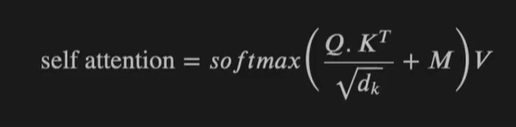

First calculate dot product between q and k transpose matrix

In [66]:
np.matmul(q,k.T)

array([[-1.36260171, -1.00846343,  0.83830779, -1.10325174],
       [ 2.76055142, -5.37365317, -5.91054408,  3.86834114],
       [ 0.83956039, -0.89236221, -1.56808315,  1.9914997 ],
       [ 1.4558852 , -6.19223184, -4.35573576,  5.09868666]])

Why we need sqrt(d_k) in denominator

In [67]:
q.var(), k.var(), np.matmul(q, k.T).var()

(1.0062948343438747, 1.0562895664061145, 11.068915998163352)

You can see that the variance range for np.matmul(q, k.T), this is so high as compared to range of q and k matrix. Make same range we are deviding

In [68]:
scaled = np.matmul(q, k.T) / math.sqrt(d_k)
q.var(), k.var(), scaled.var()

(1.0062948343438747, 1.0562895664061145, 1.383614499770419)

In [69]:
scaled

array([[-0.48175246, -0.35654566,  0.29638656, -0.39005839],
       [ 0.97600231, -1.8998733 , -2.0896929 ,  1.36766513],
       [ 0.29682942, -0.31549769, -0.55440112,  0.70410147],
       [ 0.51473315, -2.18928456, -1.53998515,  1.80265795]])

### Masking  
* this is to ensure words dont get context from words generated in the future  
* Not required in the encoders, but required in the decoders

In [70]:
mask = np.tril(np.ones((L, L)))
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [71]:
# mask[mask == 0] = -np.infty
mask[mask == 0] = -np.infty
mask[mask == 1] = 0

mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

In [72]:
scaled + mask

array([[-0.48175246,        -inf,        -inf,        -inf],
       [ 0.97600231, -1.8998733 ,        -inf,        -inf],
       [ 0.29682942, -0.31549769, -0.55440112,        -inf],
       [ 0.51473315, -2.18928456, -1.53998515,  1.80265795]])

### Softmax  
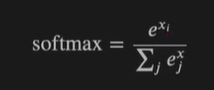

In [73]:
def softmax(x):
    return (np.exp(x).T / np.sum(np.exp(x), axis=-1)).T

In [74]:
print(np.exp(scaled + mask))
np.sum(np.exp(scaled + mask), axis=-1)

[[0.61769995 0.         0.         0.        ]
 [2.65382585 0.14958757 0.         0.        ]
 [1.34558575 0.72942576 0.57441617 0.        ]
 [1.67319195 0.11199685 0.21438429 6.06574854]]


array([0.61769995, 2.80341342, 2.64942768, 8.06532162])

In [75]:
attention = softmax(scaled + mask)
attention

array([[1.        , 0.        , 0.        , 0.        ],
       [0.94664092, 0.05335908, 0.        , 0.        ],
       [0.50787789, 0.27531446, 0.21680764, 0.        ],
       [0.20745508, 0.01388622, 0.026581  , 0.7520777 ]])

In [76]:
new_v = np.matmul(attention, v)
new_v

array([[-0.86809855, -1.18069928, -0.06732257, -0.07734407,  0.90038494,
         0.98346644,  1.78747552,  1.74595429],
       [-0.80533354, -0.99471947, -0.08073652, -0.00649675,  0.8041906 ,
         1.04012565,  1.6762444 ,  1.54688036],
       [-0.49883119,  0.16491485,  0.14500971,  0.44535492, -0.12936482,
         1.09460771,  0.7726493 ,  0.09295474],
       [-0.41214081,  0.49047069,  0.67251614,  0.05135334, -1.39087677,
        -0.73216931,  0.58833651,  0.32972812]])

### Put all together

In [77]:
def softmax(x):
    return (np.exp(x).T / np.sum(np.exp(x), axis=-1)).T

def scaled_dot_product_attention(q, k, v, mask=None):
    d_k = q.shape[-1]
    scaled = np.matmul(q, k.T) / np.sqrt(d_k)
    if mask is not None:
        scaled = scaled + mask

    attention = softmax(scaled)
    out = np.matmul(attention, v)
    return out, attention